# Class 1: Clustering

One important task that (almost) all scientists do is drawing borders. In the case of LCA, we have to look at the world in chaos, and divide it into a set of distinct processes, with inputs, outputs, and system boundaries. Traditionally, this division has been done based on expert judgment or as a reflection of existing divisions used in other fields or policy. However, we would like to at least attempt to use a more statistically robust method, in order to know when there are real differences between processes, and when distinct processes can be aggregated together.

For our case study, we will take a database of almost 7000 motorcycles, and see if we can figure out what classes to split these vehicles into, using the [scikit-learn](http://scikit-learn.org/stable/index.html) machine learning library.

First, we will go through [another scipy lecture](http://www.scipy-lectures.org/packages/scikit-learn/index.html), and then look at an example of [multiple clustering methods](http://nbviewer.ipython.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb).

## Getting set up

Make sure you have scikit-learn and seaborn installed:

In Windows, open a new command window, and enter the following:

    cd C:\bw2-python\
    bw2-env.bat
    conda install -y -q seaborn scikit-learn
    
In OS X, open a new terminal window, and enter the following:

    source ~/bw2-python/envs/bw2/bin/activate
    conda install -y -q seaborn scikit-learn
    
Also, you should have ``ecoinvent 2.2`` imported.

In [1]:
from brightway2 import *
import xlrd
import numpy as np
import pyprind
import sklearn.cluster as cluster
import time

New project for a new class. But copy over `ecoinvent`.

In [2]:
if 'Class 3' not in projects:
    projects.current = "Class 1"
    projects.copy_project("Class 3")

In [3]:
projects.current = "Class 3"

In [4]:
list(databases)

['biosphere3', 'ecoinvent 2.2']

# Motorcycle physics model

We will calculate the energy consumption of a motorcycle based on a simple physics model by Brian Cox. This uses the World Motorcycle Test Cycles to estimate average motorcycle usage. The test cycle varies based on engine size.

In [5]:
class Motorcycle(object):
    def __init__(self, dry_weight, displacement, power, fuel_capacity, name, year, **kwargs):
        # ~0.6 kg/l density of gasoline, assume half full, 10l if no info
        self.mass = dry_weight + (fuel_capacity or 10.) * 0.6  * 0.5  
        self.power = power
        self.displacement = displacement
        self.name = name
        self.year = year
        self.ttw = self.get_ttw()  # Tank to wheel
        self.idling_consumption = 1.
        self.Af = self.get_Af()
        self.coefficient_drag = 0.6
        self.coefficient_resist = 0.01
        self.recup_efficiency = 0.  # No electric bikes, no recuperation

    def get_ttw(self):
        return 0.15 * 1.04 ** (self.year - 2015)

    def get_Af(self):
        if self.displacement < 50:
            return 0.4
        elif self.displacement < 100:
            return 0.5
        elif self.displacement < 500:
            return 0.6
        else:
            return 0.8

In [6]:
class MotorcycleEnergyConsumption(object):
    def __init__(self):
        self.cycles = self.get_driving_cycles()
        self.RHO_AIR = 1.2  # air density for aerodynamic calculations

    def get_driving_cycles(self):
        wb = xlrd.open_workbook("files/WMTC.xlsx")
        ws = wb.sheet_by_name("Sheet1")
        headers = [ws.cell(0, x).value for x in range(1, ws.ncols)]
        return {header: np.array([float(ws.cell(row, index + 1).value)
                                  for row in range(1, ws.nrows)
                                  if ws.cell(row, index + 1).value != ''])
                for index, header in enumerate(headers)}

    def get_section_weights(self, displacement):
        if displacement < 100:
            return (slice(600),), (1.,)
        elif displacement < 500:
            return (slice(600), slice(600, 1200)), (0.3, 0.7, 0)
        else:
            return (slice(600), slice(600, 1200), slice(1200, 1800)), (0.25, 0.5, 0.25)

    def get_driving_cycle(self, displacement):
        if displacement < 100:
            return self.cycles[1.1]
        elif displacement < 500:
            return self.cycles[2.1]
        else:
            return self.cycles[3.2]

    def get_energy_consumption(self, bike):
        def slice_and_sum(lst):
            obj = [lst[sl].sum() / 1000. for sl in slices]
            obj.append(add_weighted_sum(obj))
            return np.array(obj)

        cycle = self.get_driving_cycle(bike.displacement)
        slices, weights = self.get_section_weights(bike.displacement)

        velocity = cycle / 3.6  # Unit conversion?
        acceleration = velocity * 0
        acceleration[:-1] = velocity[1:] - velocity[:-1]

        kinetic_force = acceleration * bike.mass
        rolling_resistance = np.ones(cycle.shape) * bike.mass * bike.coefficient_resist * 9.81
        air_resistance = (velocity ** 2 * bike.coefficient_drag
                          * bike.Af * self.RHO_AIR / 2)

        # Total force required at the wheel to meet acceleration requirement. rolling and
        # air resistance are always positive (resisting motion) but kinetic force
        # can be negative, when the bike is decelerating.
        total_force = kinetic_force + rolling_resistance + air_resistance
        power = total_force * velocity
        idling = (velocity == 0) * 1

        arrays = np.recarray(
            velocity.shape,
            dtype=[(col, float) for col in 'kraw']
        )

        arrays.k = kinetic_force * velocity
        arrays.r = rolling_resistance * velocity
        arrays.a = air_resistance * velocity
        arrays.w = power  # arrays.k + arrays.r + arrays.a

        decelerating = total_force < 0

        pa = arrays.copy()
        pa[decelerating] = (0,0,0,0)  # Four columns of zeros; special handling for recarrays
        pd = arrays.copy()
        pd[~decelerating] = (0,0,0,0)

        recuperated_power = pd.w * bike.recup_efficiency

        add_weighted_sum = lambda lst: sum([x * y for x, y in zip(lst, weights)])

        # Convert to km; velocity is m/s, times 1 second
        distance = slice_and_sum(velocity)

        ttw_idle = [idling[sl].sum() * bike.idling_consumption for sl in slices]
        ttw_idle.append(add_weighted_sum(ttw_idle))
        ttw_idle = np.array(ttw_idle)

        return (
            slice_and_sum(pa.w) / distance,  # Traction
            ttw_idle / distance,             # Idling
            slice_and_sum(recuperated_power) / distance / bike.ttw,  # Recuperated
            slice_and_sum(pa.k) / distance / bike.ttw,  # Kinetic
            slice_and_sum(pa.r) / distance / bike.ttw,  # Rolling
            slice_and_sum(pa.a) / distance / bike.ttw   # Aero
        )

    def __call__(self, bike):
        return sum([x[-1] # Only want last number, which is average
                   for x in self.get_energy_consumption(bike)
                   ]) / 1000.  # Convert to kWh

In [7]:
mec = MotorcycleEnergyConsumption()

## Test motorcycle

Test motorcycle is 4 kW moped. Run over a test cycle of ~10 minutes, should use around half a kilowatt hour.

In [8]:
test_motorcycle = Motorcycle(155, 50, 0, 0, 'foo', 2010)
mec(test_motorcycle)

0.465311680018342

Good, this seems reasonable.

# Motorcycle database

Next, we need to know about every motorcycle ever made. We can't get that, but we can scrape http://www.motorcycledb.com/ for data on alomst 7000 motorcycles. The scraping has been done already, we will just load the results here.

In [9]:
def get_motorcycle_database():
    wb = xlrd.open_workbook("files/motorcycles.xlsx")
    ws = wb.sheet_by_name("Sheet1")
    columns = ['name', 'dry_weight', 'power', 'fuel_capacity', 'displacement', 
               'engine_type', 'model', 'category', 'year']
    return [{col: ws.cell(row, index + 1).value
             for index, col in enumerate(columns)}
           for row in range(1, ws.nrows)]

In [10]:
motorcycles = [obj for obj in get_motorcycle_database()
               if obj['displacement']
               and obj['engine_type'] != 'Electric']

Make sure names of the motorcycles are unique.

In [11]:
motorcycles = list({obj['name']: obj for obj in motorcycles}.values())

In [12]:
len(motorcycles)

6853

Add energy consumption (in kg petrol/km), as well as relative CO2 and NOx emissions.

In [13]:
for obj in motorcycles:
    # Convert from kWh to kg gasoline: 12.33 kWh / kg gasoline
    obj['energy'] = mec(Motorcycle(**obj)) / 12.33  # kg gasoline / km
    obj['co2'] = obj['energy'] * 3.2338  # kg CO2/km, assume constant factor
    obj['nox'] = 0.0001 * np.exp(-0.045 * (int(obj['year'] - 2015))) # kg NOx / km, regression from test data.

In [14]:
motorcycles[0]

{'category': 'Enduro / offroad',
 'co2': 0.48702503855141605,
 'displacement': 1130.0,
 'dry_weight': 175.0,
 'energy': 0.15060456384173915,
 'engine_type': 'Two cylinder boxer',
 'fuel_capacity': 13.0,
 'model': 'BMW HP2 Enduro',
 'name': 'BMW HP2 Enduro (2007)',
 'nox': 0.00014333294145603401,
 'power': 105.0,
 'year': 2007.0}

# Motorcycle LCI inventories

Now we want to create each motorcycle as a new process in a new LCI database. We will link to several background processes in ecoinvent, we we need to find first:

In [15]:
db = Database('ecoinvent 2.2')
scooter_maintenance = db.search('maintenance scooter')[0]  # Assumes 90 kg of mass
scooter_disposal = db.search('disposal scooter')[0]
scooter_body = db.search("scooter regional storage")[0]
petrol = db.search("petrol low-sulphur regional storage")[1]
db = Database('biosphere3')
co2 = db.search("carbon dioxide fossil")[0]
nox = db.search("nitrogen oxides")[0]

Check to make sure the searching worked

In [16]:
scooter_maintenance, scooter_disposal, scooter_body, petrol, co2, nox

('maintenance, scooter' (unit, CH, ['transport systems', 'road']),
 'disposal, scooter' (unit, CH, ['transport systems', 'road']),
 'scooter, ICE, at regional storage' (unit, RER, ['transport systems', 'road']),
 'petrol, low-sulphur, at regional storage' (kilogram, RER, ['oil', 'fuels']),
 'Carbon dioxide, fossil' (kilogram, None, ('air',)),
 'Nitrogen oxides' (kilogram, None, ('air',)))

Add LCI data to each motorcycle:

In [17]:
for obj in motorcycles:
    obj['unit'] = 'person kilometer'
    obj['exchanges'] = [
        {'input': co2.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['co2'],
         'uncertainty type': 0,
         'type': 'biosphere'
        },
        {'input': nox.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['nox'],
         'uncertainty type': 0,
         'type': 'biosphere'
        },
        {'input': scooter_maintenance.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['dry_weight'] / 90. * 1.81e-5,
         'uncertainty type': 0,
         'type': 'technosphere'
        },
        {'input': scooter_disposal.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['dry_weight'] / 90. * 1.81e-5,
         'uncertainty type': 0,
         'type': 'technosphere'
        },
        {'input': scooter_body.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['dry_weight'] / 90. * 1.81e-5,
         'uncertainty type': 0,
         'type': 'technosphere'
        },
        {'input': petrol.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['energy'],
         'uncertainty type': 0,
         'type': 'technosphere'
        },
    ]

Create and write the ``motorcycle`` database. Note that, because Brightway2 is a document database, we can keep and retrieve all our motorcycle-specific fields in each process without any problems.

In [18]:
db = Database("motorcycles")

In [19]:
db.write({('motorcycles', obj['name']): obj for obj in motorcycles})

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 6.840 sec


Title: Writing activities to SQLite3 database:
  Started: 10/19/2015 23:16:27
  Finished: 10/19/2015 23:16:34
  Total time elapsed: 6.840 sec
  CPU %: 87.200000
  Memory %: 2.629423


# Add LCA results to each motorcycle

First, define two methods we care about:

In [20]:
gwp = ('IPCC 2013', 'climate change', 'GWP 100a')
smog = ('ReCiPe Endpoint (E,A)', 'human health', 'photochemical oxidant formation')

Next, set up an LCA object for multiple calculations:

In [21]:
lca = LCA({db.random(): 1}, method=gwp)
lca.lci(factorize=True)
lca.lcia()

Get and add the GWP score to each motorcycle:

In [22]:
for obj in pyprind.prog_bar(motorcycles):
    lca.redo_lcia({('motorcycles', obj['name']): 1})
    obj['gwp'] = lca.score

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 39.030 sec


Switch to the other LCIA method and calculate for each motorcycle.

In [23]:
lca.method = smog
lca.load_lcia_data()

In [24]:
for obj in pyprind.prog_bar(motorcycles):
    lca.redo_lcia({('motorcycles', obj['name']): 1})
    obj['smog'] = lca.score

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 37.509 sec


# Database visualization

Let's look a bit at some of the data we generated.

In [25]:
%matplotlib inline

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

sns.set(style="white", palette="muted", color_codes=True, context='poster')

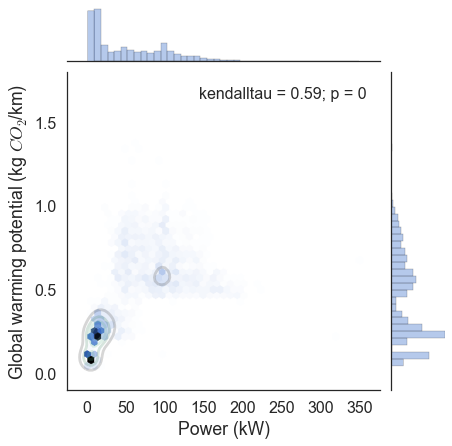

In [27]:
sns.jointplot(
    np.array([x['power'] for x in motorcycles]),
    np.array([x['gwp'] for x in motorcycles]),
    kind='hex',
    stat_func=kendalltau,
).plot_joint(sns.kdeplot, zorder=1, n_levels=6, alpha=0.2)
plt.xlabel("Power (kW)")
plt.ylabel(r"Global warming potential (kg $CO_{2}$/km)")

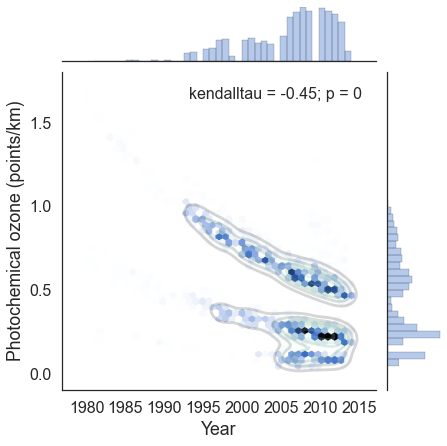

In [28]:
sns.jointplot(
    np.array([x['year'] for x in motorcycles]),
    np.array([x['smog'] for x in motorcycles]),
    kind='hex',
    stat_func=kendalltau,
).plot_joint(sns.kdeplot, zorder=1, n_levels=6, alpha=0.2)
plt.xlabel("Year")
plt.ylabel("Photochemical ozone (points/km)")

# Classification

Finally, we are ready to classify. We aren't going to do classification with categorized data today, so we will stick with our continuous, numerical variables that we are interested in understanding.

* displacement
* power
* dry_weight
* co2
* smog
* year

Aggregate all these values into a NumPy array:

In [29]:
data = np.array([[
    obj['displacement'],
    obj['power'],
    obj['dry_weight'],
    obj['co2'],
    obj['smog'],
    obj['year'],
    obj['energy']
] for obj in motorcycles])
data.shape

(6853, 7)

Set up function to visualize the results of multiple clustering algorithms:

In [30]:
plot_kwds = {'alpha' : 0.1, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    print('Clustering took {:.2f} s'.format(time.time() - start_time))

    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    plt.figure(0)
    plt.scatter(data.T[1], data.T[3], c=colors, **plot_kwds)
    plt.xlabel("Power (kW)")
    plt.ylabel(r"Global warming potential (kg $CO_{2}$/km)")    

    plt.figure(1)
    plt.scatter(data.T[0], data.T[2], c=colors, **plot_kwds)
    plt.xlabel("Displacement (CC)")
    plt.ylabel("Dry weight (kg)")    

    plt.figure(2)
    plt.scatter(data.T[6], data.T[5], c=colors, **plot_kwds)
    plt.xlabel("Energy (kWh/km)")
    plt.ylabel("Year")    

Let's start with DBSCAN, which was recommended in the previous notebook:

Clustering took 0.17 s


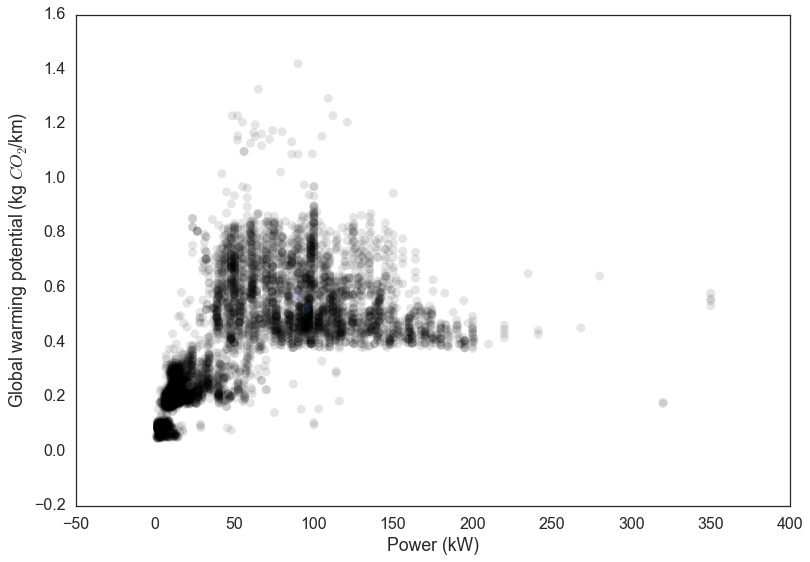

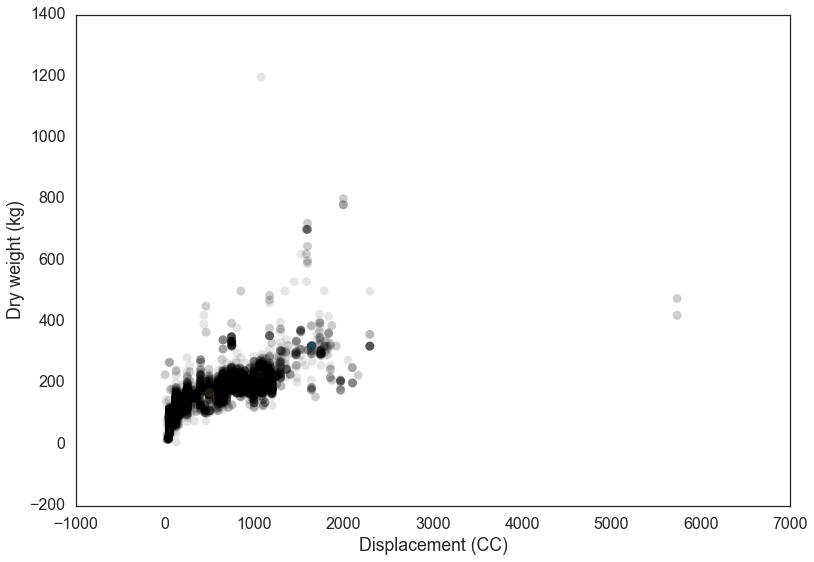

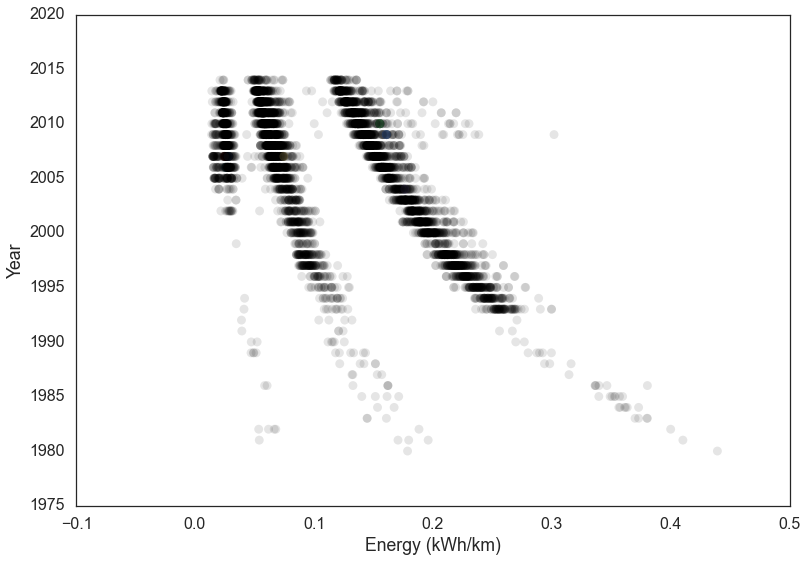

In [31]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

OK, that didn't... work. What about good old K-means?

Clustering took 0.05 s


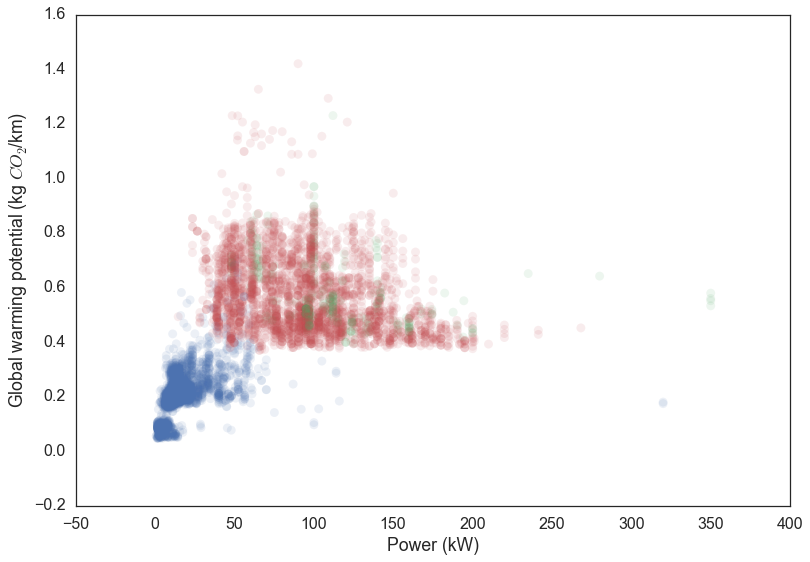

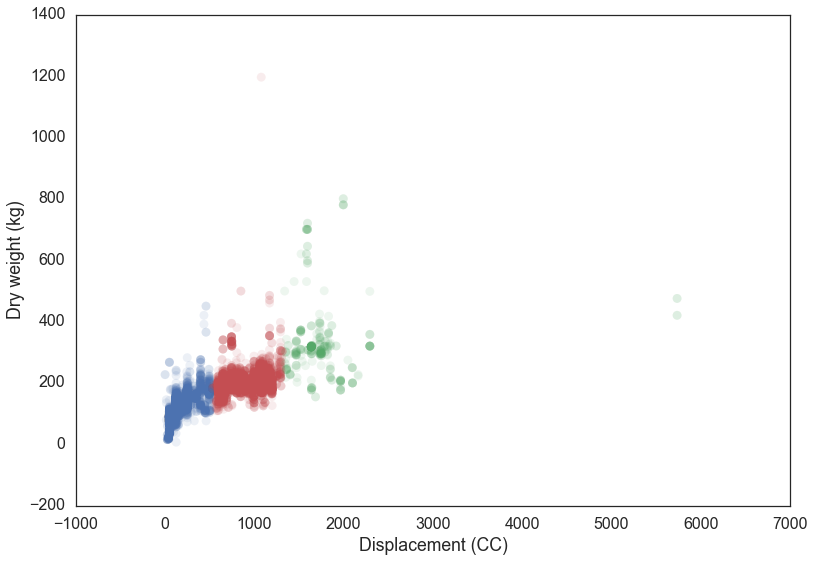

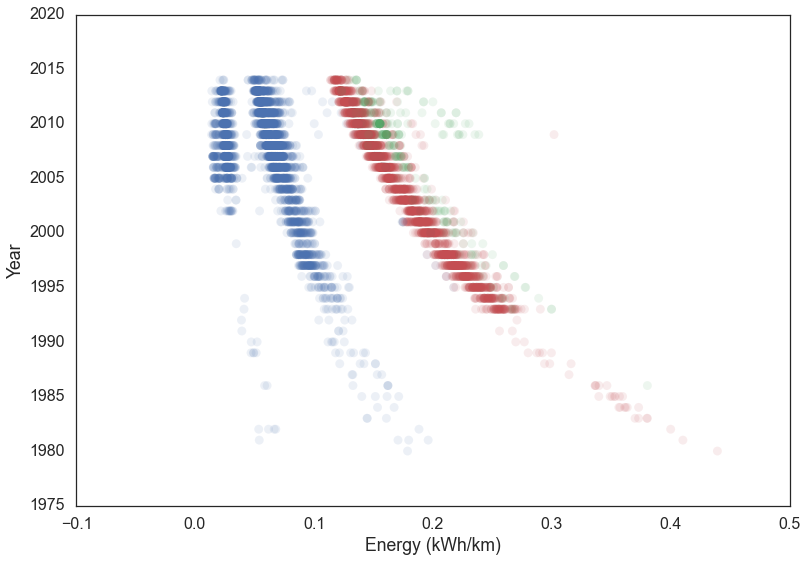

In [30]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters': 3})

And with more clusters?

Clustering took 0.07 s


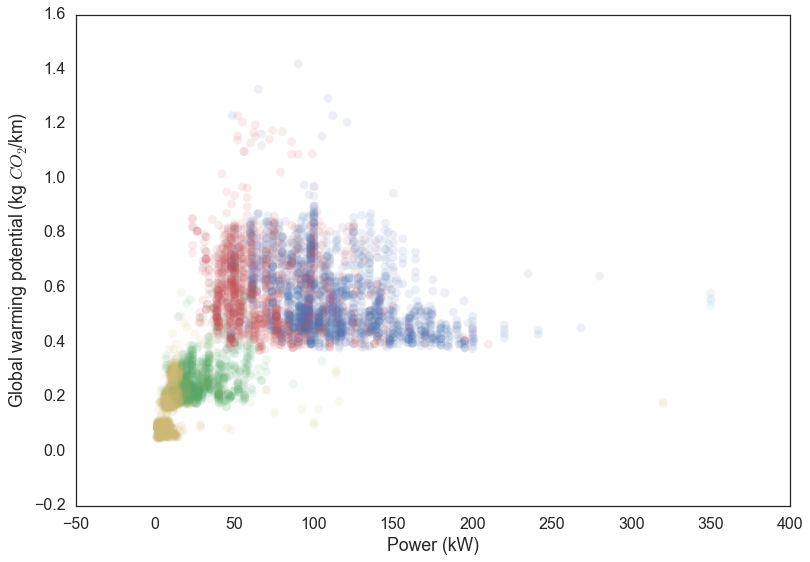

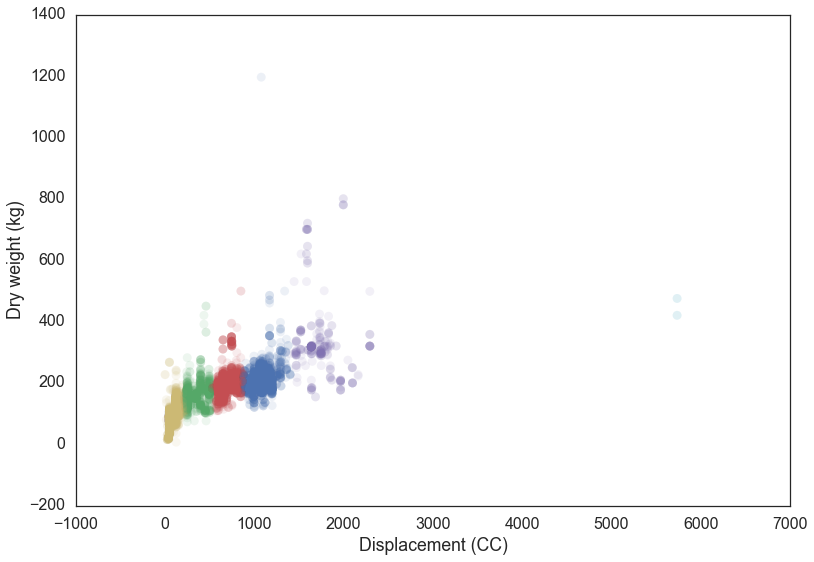

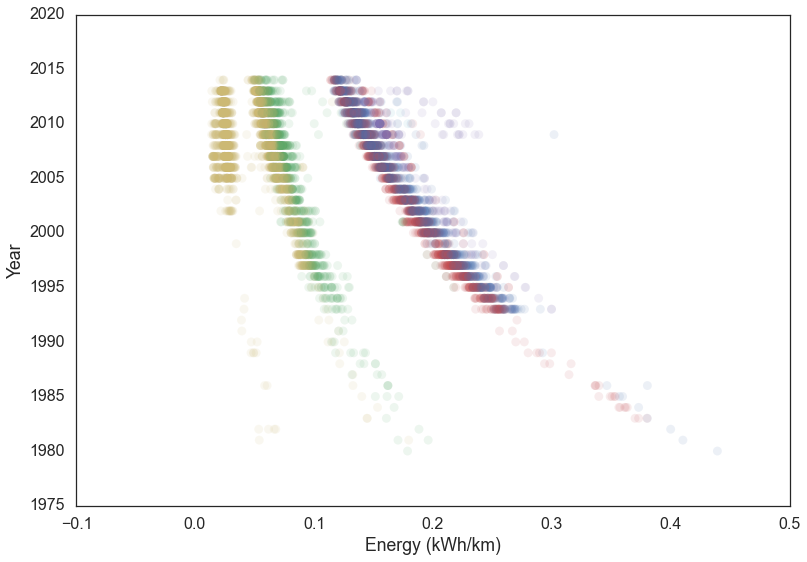

In [33]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters': 6})

Let's try another algorithm:

Clustering took 169.78 s


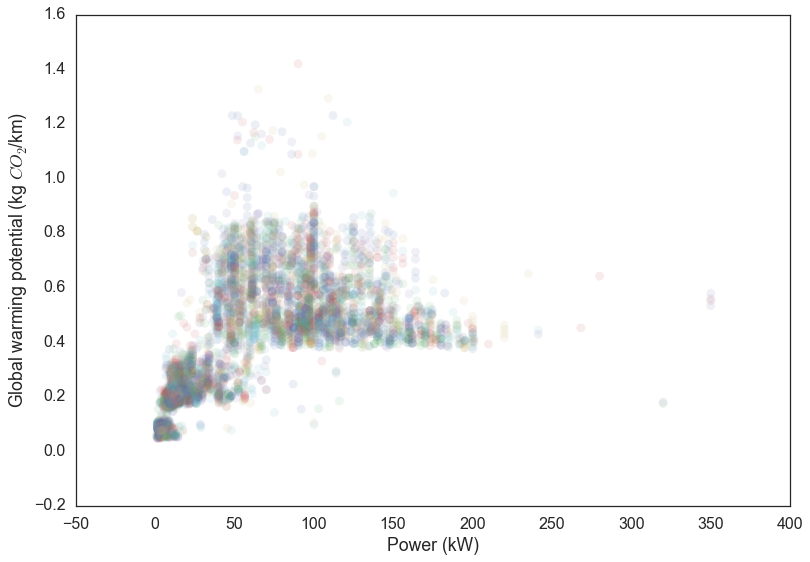

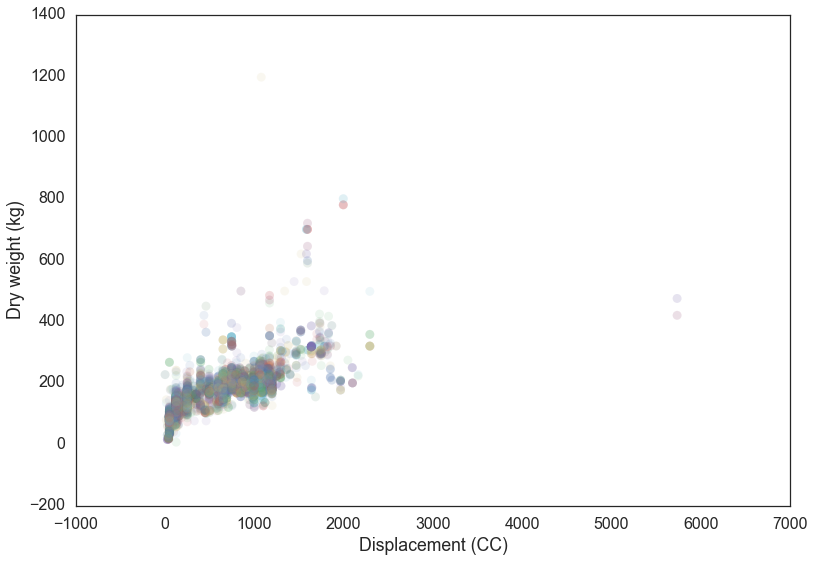

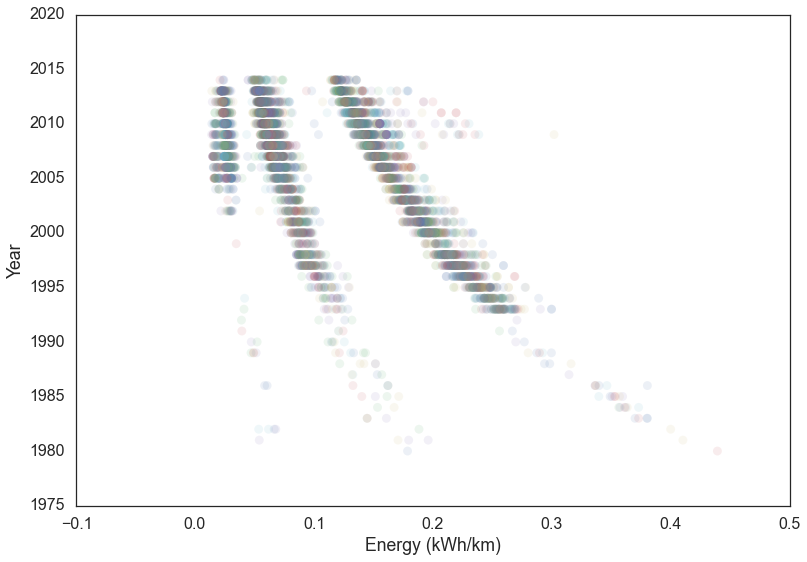

In [32]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

I tried others, but some are way too slow. Feel free to try yourself!

# Dimensionality reduction

A fancy way of saying "Too many parameters!" Techniques like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) can reproject your data into fewer dimensions (parameters).

In [32]:
from sklearn.decomposition import PCA, FactorAnalysis

Try a PCA with 4 dimensions:

In [33]:
pca = PCA(4)
pca.fit(data)

PCA(copy=True, n_components=4, whiten=False)

The first dimension is explaining almost all the variance - our model is quite linear in the parameters we chose. In general, this makes sense for combustion transport processes, where most impacts come from the tailpipe, and larger engines are less efficient per passenger kilometer.

In [34]:
pca.explained_variance_ratio_

array([  9.87840024e-01,   9.39717763e-03,   2.62395074e-03,
         1.38773204e-04])

We can reproject and plot our data. Note that we don't yet understand the dimensions.

In [35]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    print('Clustering took {:.2f} s'.format(time.time() - start_time))

    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    plt.xlabel("Axis 1")
    plt.ylabel("Axis 2")    

Clustering took 0.19 s


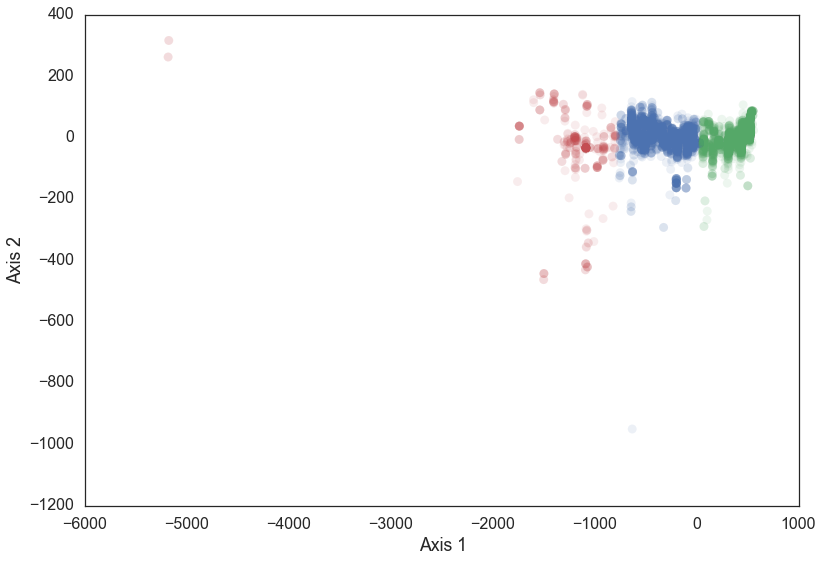

In [36]:
plot_clusters(pca.fit_transform(data), cluster.KMeans, (), {'n_clusters': 3})

Here are the slopes of the first dimension vector.

Again, the dimensions are:

* displacement
* power
* dry_weight
* co2
* smog
* year
* energy consumption

In [42]:
pca.components_[0]

array([ -9.89655233e-01,  -8.54176504e-02,  -1.15255393e-01,
        -3.28887637e-04,  -3.93376328e-04,   1.50534770e-03,
        -1.01703147e-04])

We can also use other strategies for feature reduction. In particular, once we have our prospective labels, we can use feature reduction strategies to select which parameters are most important in predicting the observed classifications.

Here is an example using [Recursive feature selection](http://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination)

In [55]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR, SVC

labels = cluster.KMeans(n_clusters=3).fit_predict(data)

estimator = SVC(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(data, labels)
print(selector.support_)
print(selector.ranking_)

[ True False False False False False False]
[1 3 4 6 5 2 7]


Now we need to thnk about what this really means. We can understand our model, but our model is a function of the input parameters, which we chose based on what we thought was important, but also what was convenient for us (based on data availability, data types, our own biases and background, etc.)